In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [2]:
df = pd.read_excel('/home/user/Downloads/Online Retail.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.dropna(inplace = True)

In [27]:
df['InvoiceNo'].unique()

array([536365, 536366, 536367, ..., 581585, 581586, 581587], dtype=object)

 Let's remove all the entries with C in data as those products are returned.

In [8]:
df = df[~df['InvoiceNo'].str.contains("C",na=False)]

#### Recency

In [9]:
df.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

In [10]:
today_date = dt.datetime(2011,12,9) # last invoice date is assigned to today_date variable

In [11]:
# The type of Customer ID variable needs to be turned into an integer for following commands.
df["CustomerID"] = df["CustomerID"].astype(int) 



In [12]:
# The type of InvoiceDate variable needs to be turned into datetime for following commands.
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [13]:
# Grouping the last invoice dates according to the Customer ID variable, subtracting them from today_date, and assigning them as recency
recency = (today_date - df.groupby("CustomerID").agg({"InvoiceDate":"max"}))
# Rename column name as Recency
recency.rename(columns = {"InvoiceDate":"Recency"}, inplace = True)
# Change the values to day format
recency_df = recency["Recency"].apply(lambda x: x.days)
recency_df.describe()

count    4339.000000
mean       91.041484
std       100.007757
min        -1.000000
25%        16.000000
50%        49.000000
75%       140.500000
max       372.000000
Name: Recency, dtype: float64

#### Frequency

In [14]:
# Grouping unique values of invoice date according to customer_id variable and assigning them to freq_df variable
freq_df = df.groupby("CustomerID").agg({"InvoiceDate":"nunique"}) 
# Rename column name as Frequency
freq_df.rename(columns={"InvoiceDate": "Frequency"}, inplace=True)
freq_df.head()

,Frequency
CustomerID,
12346,1
12347,7
12348,4
12349,1
12350,1


#### Monetary

In [15]:
# Multiplying the prices and quantities of purchased products and assigning them to the total price variable
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [16]:
# Grouping and sum up total prices according to each Customer ID
monetary_df = df.groupby("CustomerID").agg({"TotalPrice":"sum"})
# Rename Total Price column as Monetary
monetary_df.rename(columns={"TotalPrice":"Monetary"}, inplace=True)
monetary_df.head()

,Monetary
CustomerID,
12346,77183.60
12347,4310.00
12348,1797.24
12349,1757.55
12350,334.40


#### Concatenate Recency,Frequency and Monetary

In [17]:
rfm = pd.concat([recency_df, freq_df, monetary_df],  axis=1)
rfm = rfm[~rfm['Recency']<0]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,324,1,77183.60
12347,1,7,4310.00
12348,74,4,1797.24
12349,17,1,1757.55
12350,309,1,334.40


In [18]:
rfm.describe()

,Recency,Frequency,Monetary
count,4304.000000,4304.000000,4304.000000
mean,91.789963,4.111059,1900.703925
std,100.067154,6.743446,7613.442558
min,0.000000,1.000000,0.000000
25%,17.000000,1.000000,306.370000
50%,50.000000,2.000000,665.315000
75%,142.000000,5.000000,1628.370000
max,372.000000,201.000000,280206.020000


### Visualising RFM Dist

In [28]:
fig = make_subplots(rows=3, cols=1,
                   subplot_titles=("Recency","Frequency","Monetary"))

fig.append_trace(go.Histogram(x=rfm.Recency),
                 row=1, col=1)

fig.append_trace(go.Histogram(x=rfm.Frequency),
                 row=2, col=1)

fig.append_trace(go.Histogram(x=rfm.Monetary),
                 row=3, col=1)

fig.update_layout(height=800, width=800,
                  title_text="Distribution of the Features")

fig.show()

### Scale Transformation

In [20]:
def apply_log1p_transformation(dataframe, column):
    '''This function takes a dataframe and a column in the string format
    then applies numpy log1p transformation to the column
    as a result returns log1p applied pandas series'''
    
    dataframe["log_" + column] = np.log1p(dataframe[column])
    return dataframe["log_" + column]


In [21]:
apply_log1p_transformation(rfm,'Recency')
apply_log1p_transformation(rfm,'Frequency')
apply_log1p_transformation(rfm,'Monetary')

CustomerID
12346    11.253955
12347     8.368925
12348     7.494564
12349     7.472245
12350     5.815324
           ...    
18280     5.201806
18281     4.404522
18282     5.187665
18283     7.647729
18287     7.516586
Name: log_Monetary, Length: 4304, dtype: float64

### Visualize log transformation applied features

In [29]:
fig = make_subplots(rows=3, cols=1,
                   subplot_titles=("Recency","Frequency","Monetary"))

fig.append_trace(go.Histogram(x=rfm.log_Recency),
                 row=1, col=1)

fig.append_trace(go.Histogram(x=rfm.log_Frequency),
                 row=2, col=1)

fig.append_trace(go.Histogram(x=rfm.log_Monetary),
                 row=3, col=1)

fig.update_layout(height=800, width=800,
                  title_text="Distribution of the log transformed Features")

fig.show()

In [30]:
rfm.head()

,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary
CustomerID,,,,,,
12346,324,1,77183.60,5.783825,0.693147,11.253955
12347,1,7,4310.00,0.693147,2.079442,8.368925
12348,74,4,1797.24,4.317488,1.609438,7.494564
12349,17,1,1757.55,2.890372,0.693147,7.472245
12350,309,1,334.40,5.736572,0.693147,5.815324



.

### Clustering the customers

In [23]:
#find the optimum number of clusters

def num_of_k(k, data):
    cluster_values = list(range(1,k))
    inertia_values = []
    for c in cluster_values:
        model = KMeans(
            n_clusters = c,
            init = 'k-means++',
            max_iter = 500,
            random_state = 42)
        model.fit(data)
        inertia_values.append(model.inertia_)
        
    return inertia_values

#inertia value tells how fit the clusters are created with least euclidian distance in every cluster

In [24]:
results = num_of_k(12,rfm.iloc[:,3:])

In [25]:
rfm.iloc[:,3:].describe()
#issue with log_Recency

,log_Recency,log_Frequency,log_Monetary
count,4304.000000,4304.000000,4304.000000
mean,3.767268,1.334566,6.575616
std,1.441322,0.669600,1.246153
min,0.000000,0.693147,0.000000
25%,2.890372,0.693147,5.728052
50%,3.931826,1.098612,6.501762
75%,4.962845,1.791759,7.395949
max,5.921578,5.308268,12.543284


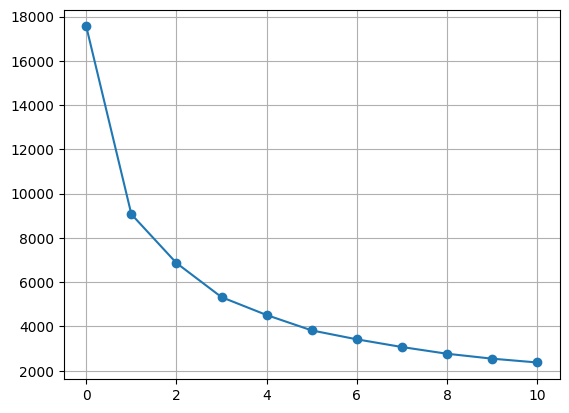

In [26]:
plt.grid()
plt.plot(results,marker='o')


With the elbow method, we are going to select the k value where the decrease in the inertia stabilizes.

When k=1 inertia is at the highest, meaning data is not grouped yet. Inertia decreases steeply until k=2. Between k=2 and 4, the curve continues to decrease fast.

At k=4, the descent stabilizes and continues linearly afterwards, forming an elbow at k=4. This points out the optimal number of customer group is 4.

In [31]:
# create clustering model with optimal k=4
updated_kmeans_model = KMeans(n_clusters = 4, 
                              init='random', 
                              max_iter=500, 
                              random_state=42)
updated_kmeans_model.fit_predict(rfm.iloc[:,3:])

array([1, 3, 1, ..., 0, 3, 1], dtype=int32)

In [32]:
updated_kmeans_model.cluster_centers_

array([[2.91984127, 1.03220243, 5.88818367],
       [3.94899532, 1.59055598, 7.36973418],
       [5.14160836, 0.85121991, 5.61297871],
       [1.63906341, 2.3046628 , 8.13856099]])

#### Add cluster center to the visualiozation

In [33]:
# create cluster centers and actual data arrays
cluster_centers = updated_kmeans_model.cluster_centers_
actual_data = np.expm1(cluster_centers)
add_points = np.append(actual_data, cluster_centers, axis=1)
add_points

array([[1.75383446e+01, 1.80724180e+00, 3.59749449e+02, 2.91984127e+00,
        1.03220243e+00, 5.88818367e+00],
       [5.08832144e+01, 3.90647609e+00, 1.58621181e+03, 3.94899532e+00,
        1.59055598e+00, 7.36973418e+00],
       [1.69990562e+02, 1.34250276e+00, 2.72959069e+02, 5.14160836e+00,
        8.51219914e-01, 5.61297871e+00],
       [4.15034348e+00, 9.02079862e+00, 3.42298717e+03, 1.63906341e+00,
        2.30466280e+00, 8.13856099e+00]])

In [34]:
# add labels to customers dataframe and add_points array
add_points = np.append(add_points, [[0], [1], [2], [3]], axis=1)
rfm["clusters"] = updated_kmeans_model.labels_

In [35]:
rfm['clusters'].value_counts()

2    1502
1    1193
0     897
3     712
Name: clusters, dtype: int64

In [37]:
# create centers dataframe from add_points
centers_df = pd.DataFrame(data=add_points, columns=['recency',
                                                    'frequency',
                                                    'monetary',
                                                    'log_recency',
                                                    'log_frequency',
                                                    'log_monetary',
                                                    'clusters'])
centers_df.head()

,recency,frequency,monetary,log_recency,log_frequency,log_monetary,clusters
0,17.538345,1.807242,359.749449,2.919841,1.032202,5.888184,0.0
1,50.883214,3.906476,1586.211808,3.948995,1.590556,7.369734,1.0
2,169.990562,1.342503,272.959069,5.141608,0.851220,5.612979,2.0
3,4.150343,9.020799,3422.987173,1.639063,2.304663,8.138561,3.0


### Visualisation of customr segmentation

In [42]:

import plotly.express as px
# visualize customer segments with a 3D plot
fig = px.scatter_3d(rfm,
                    x="log_Recency",
                    y="log_Frequency",
                    z="log_Monetary",
                    color='clusters',
                    hover_data=["Recency",
                                "Frequency",
                                "Monetary"],
                    category_orders = {"clusters": 
                                       ["0", "1", "2", "3"]}
                    )

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()



.

### Cluster Magniude

In [44]:

cardinality_df = pd.DataFrame(
    rfm.clusters.value_counts().reset_index())

cardinality_df.rename(columns={"index": "Customer Groups",
                               "clusters": "Customer Group Magnitude"},
                      inplace=True)



In [45]:
cardinality_df

,Customer Groups,Customer Group Magnitude
0,2,1502
1,1,1193
2,0,897
3,3,712


In [46]:


fig = px.bar(cardinality_df, x="Customer Groups", 
             y="Customer Group Magnitude",
             color = "Customer Groups",
             category_orders = {"Customer Groups": ["0", "1", "2", "3"]})

fig.update_layout(xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1),
                 yaxis = dict(
        tickmode = 'linear',
        tick0 = 1000,
        dtick = 1000))

fig.show()

